In [1]:
import tensorflow as tf
from utils import *
import matplotlib.pyplot as plt
from flow import Flow_v2
import numpy as np


2024-11-21 15:47:54.383091: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 15:47:54.431860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gt = np.load("results/gt.npz")
res = np.load("results/1.npz")

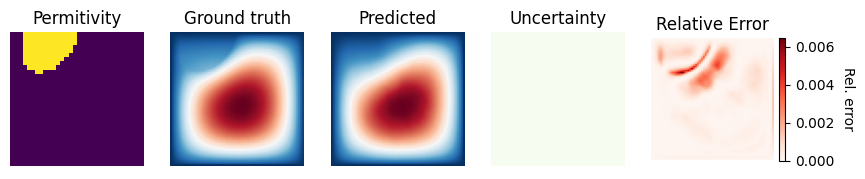

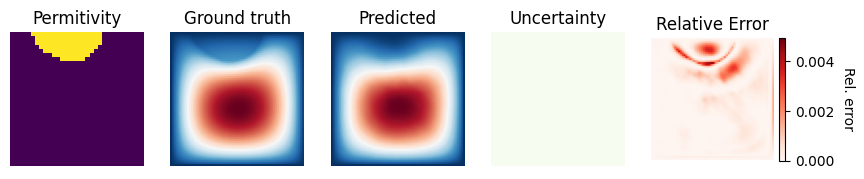

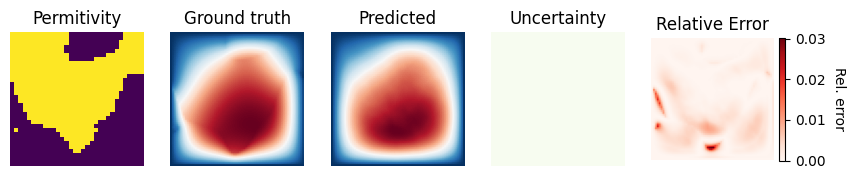

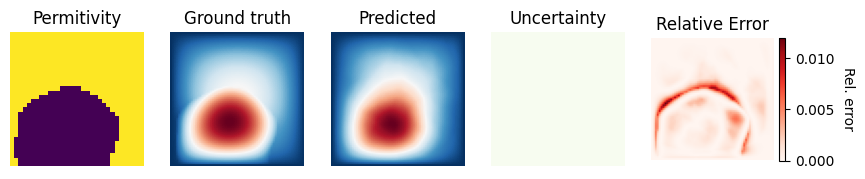

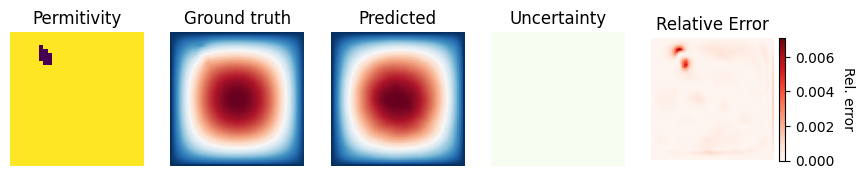

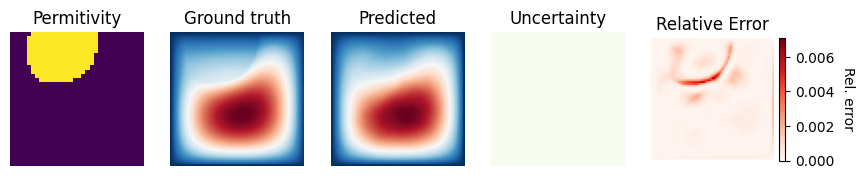

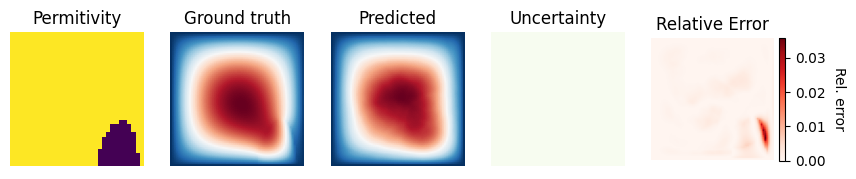

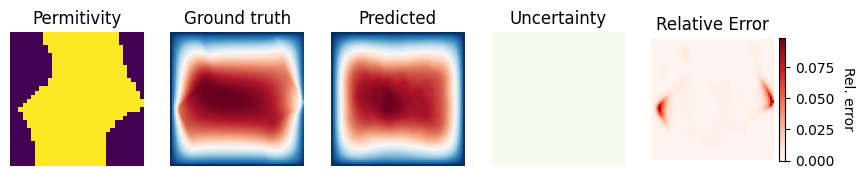

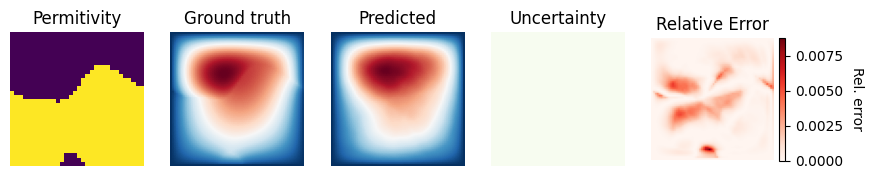

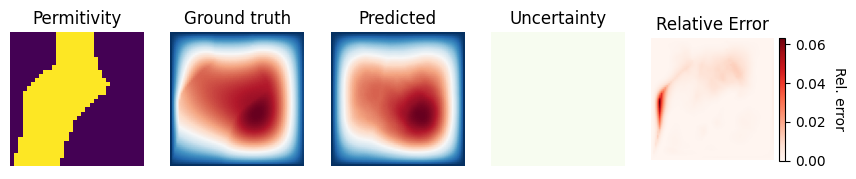

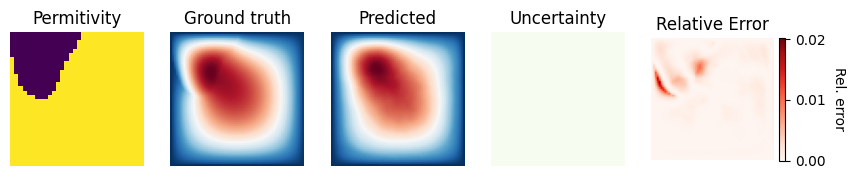

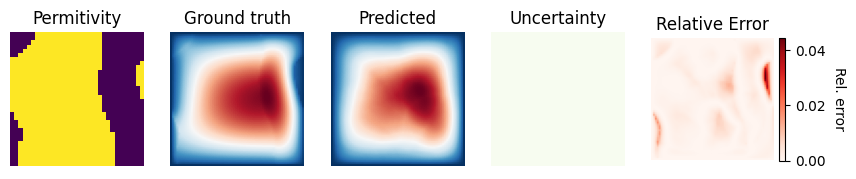

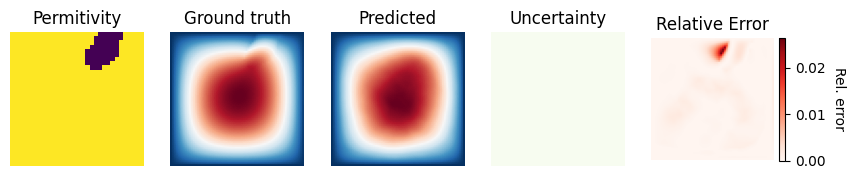

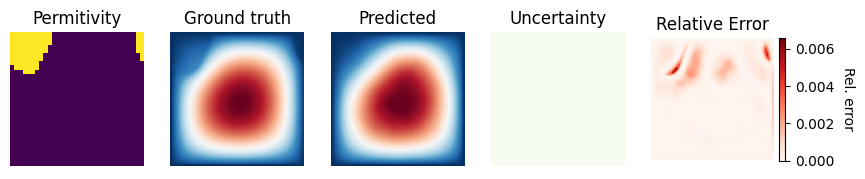

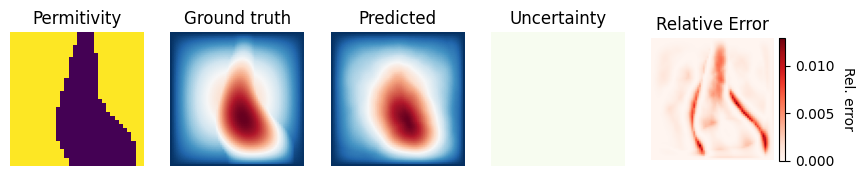

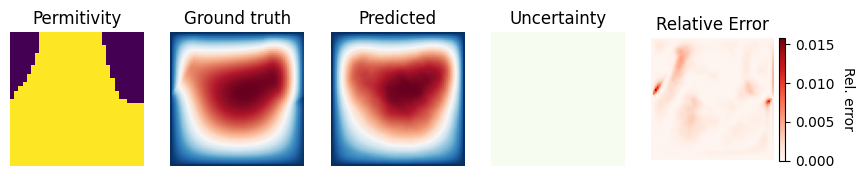

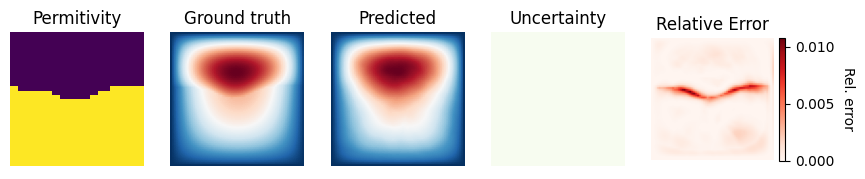

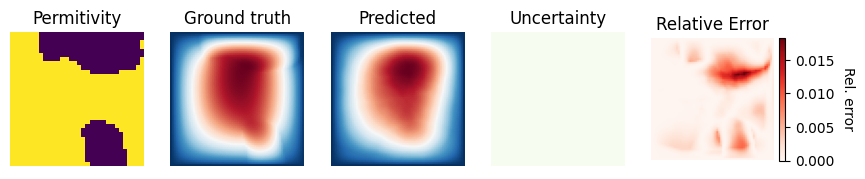

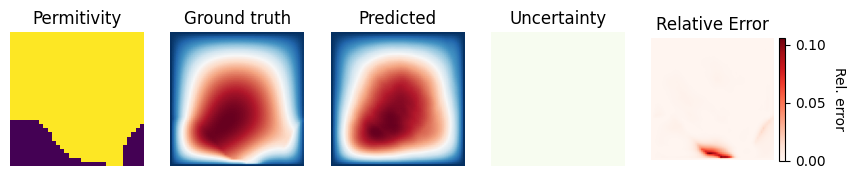

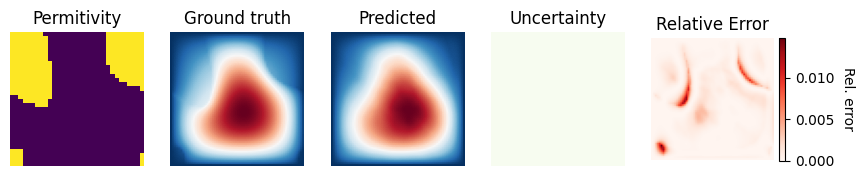

In [5]:
for (a, u, u_pred_DP, std_pred_DP, error_DP) in zip(gt['a'], gt['u'], res["u_pred_IS"], res["std_pred_IS"], res["error_IS"]):
    fig, ax = plt.subplots(1, 5, figsize=(10, 5))
 
    u_pred = tf.reshape(u_pred_DP[-1], (64,64))
    std = tf.reshape(std_pred_DP[-1], (64,64))
    error = tf.reshape(error_DP[-1], (64, 64))

    ax[0].imshow(a, cmap = "viridis")
    ax[0].set_axis_off()
    ax[0].set_title("Permitivity")
    ax[1].imshow(u, cmap = "RdBu_r")
    ax[1].set_axis_off()
    ax[1].set_title("Ground truth")
    ax[2].imshow(u_pred, cmap = "RdBu_r")
    ax[2].set_axis_off()
    ax[2].set_title("Predicted")
    ax[3].imshow(std, cmap = "GnBu")
    ax[3].set_axis_off()
    ax[3].set_title("Uncertainty")


    im3 = ax[4].imshow(error, cmap = "Reds")
    ax[4].set_axis_off()
    ax[4].set_title("Relative Error")
    cbar = fig.colorbar(im3, ax=ax[4], orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label('Rel. error', rotation=270, labelpad=15)
    plt.show()